#  Convolutional Neural Networks

<p>Convolutional Neural Networks (CNN) are special, biologically inspired variants of Multi-Layer Perceptrons. They have proven to be effective in areas such as image recognition and classification. There are four main operations that are the basic building blocks of every Convolutional Neural Network:</p>
<ol>
<li>Convolution</li>
<li>Non-Linearity</li>
<li>Pooling or Down-sampling</li>
<li>Classification or Fully Connected Layer</li>
</ol>

<img src="https://i.imgur.com/rgVIeVy.jpg" alt="Demo Architecture" title="Figure 1" width="500" />

In [1]:
import six.moves.cPickle as pickle
import gzip
import os
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import random as rd
from theano.tensor.signal import pool
from theano.tensor.nnet import conv2d
%matplotlib inline
print('***** Import complete *****')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


***** Import complete *****


<p> Load the MNIST dataset. For the training and validation set, we take 10% of training set samples. Every image can be represented as a matrix of digits where each entry represents a pixel. In the MNIST dataset, the pixels are in grey scale and normalised. The images are of dimension 28 x 28 pixels and are flattened to an array of 784 elements. 
    
If the corresponding pickle (.pkl) file is not present in the current directory, it will be downloaded for you. The dataset is partitioned into:</p>

<ul>
<li>50,000 training samples from which we draw 6000 samples.</li>
<li>10,000 validation samples from which we draw 600 samples.</li>
<li>10,000 testing samples from which we draw 2000 samples.</li>
</ul>

In [2]:
dataset = 'mnist.pkl.gz'
data_dir, data_file = os.path.split(dataset)
rd.seed(23455)
# Check if data file present
if data_dir == "" and not os.path.isfile(dataset):
    new_path = os.path.join('', dataset)
    if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
        dataset = new_path

# Download the file from MILA if not present 
if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
    from six.moves import urllib
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

print('***** Loading data *****')

# Open the file
with gzip.open(dataset, 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)

# Sub-sample and store in a tensor
def shared_dataset(data_xy, sample_size=6000, borrow=True):
    data_x, data_y = data_xy
    indices = 0
    if (sample_size < 0):
        print('Sample size too small!')
        return
    try:
        indices = rd.sample(range(0, data_y.shape[0]), sample_size)
    except ValueError:
        print('Sample size exceeds data size.')
    data_x = data_x[indices, :]
    data_y = data_y[indices]

    shared_x = theano.shared(np.asarray(data_x,
                                        dtype=theano.config.floatX),
                             borrow=borrow)
    shared_y = theano.shared(np.asarray(data_y,
                                        dtype=theano.config.floatX),
                             borrow=borrow)
    return shared_x, T.cast(shared_y, 'int32'), (data_x, data_y)

# Default training sample size = 6000 samples
# Max size = 50000
train_size = 6000
test_set_x, test_set_y, test_set = shared_dataset(
                                                  test_set,
                                                  sample_size=train_size//3
                                                 )
valid_set_x, valid_set_y, valid_set = shared_dataset(
                                                     valid_set,
                                                     sample_size=train_size//10
                                                    )
train_set_x, train_set_y, train_set = shared_dataset(
                                                     train_set,
                                                     sample_size=train_size
                                                     )
# Training set dimension: 6000 x 784
print('Training set: %d samples'
      %(train_set_x.get_value(borrow=True).shape[0])) 
# Test set dimension: 2000 x 784
print('Test set: %d samples'
      %(test_set_x.get_value(borrow=True).shape[0]))
# Validation set dimension: 2000 x 784
print('Validation set: %d samples'
      %(valid_set_x.get_value(borrow=True).shape[0]))

***** Loading data *****
Training set: 6000 samples
Test set: 2000 samples
Validation set: 600 samples


<p> Visualise a random training sample. When plotting, we scale the intensity to the range from 0 to 255. The image is of 28 x 28 pixels.</p>

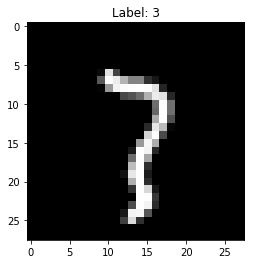

In [3]:
# Pick a random image
image_plot = rd.randint(0, len(train_set[1]))
# Scaling image to [0, 255]
pixels = np.array(train_set[0][image_plot] * 255, dtype='uint8')
pixels = pixels.reshape((28, 28))
label = train_set[1][image_plot]
plt.title('Label: {label}'.format(label=label))
plt.imshow(pixels, cmap='gray', interpolation='none')
plt.show()

<p> Create convolutional layers: The primary purpose of the convolution layer is to extract features from the image. Convolution preserves the spatial relationship between pixels by learning image features using small squares of input data (in this case 5 x 5 pixels of data). In the convolution layer, each of the filters are slid over the image by 1 pixel (stride = 1). In this demonstration, we use the non-linear, tanh function for neurons in convolutional layer. The convolutional layer will have the following specifications: </p>
<ul>
<li>9 filters or channels </li>
<li>Each filter will have a 5 x 5 "field of view"</li>
<li>The stride will be of 1.</li>
<li>It will perform 2 x 2 Max Pooling. We will define the pooling function later.</li>
<li>It will use a Tanh non-linearity</li>
<li>The function will return the outputs from the non-linearised outputs as well as the parameters (weights and biases).
</ul>

In [4]:
def convLayer(rng, data_input, filter_spec, image_spec, pool_size, activation):
    # Function that defines the convolution layer. Calls the 
    # activation function and then Pooling function.
    
    # Inputs:
    # rng - random number generator used to initialize weights.
    # data_input - symbolic input image tensor.
    # filter_spec - dimensions of filter in convolution layer.
    #               tuple format:(# of channels, depth, height, width)
    # image_spec - specifications of input images.
    #              tuple format:(batch size, color channels, height, width)
    # pool_size - specification of downsampling (pooling) factor.
    #             tuple format: (# of rows, # of columns)
    # activation - activation function to be used.
    
    # Outputs:
    # output - tensor containing activations fed into next layer.
    # params - list containing layer parameters
    
    # Creating a shared variable for weights that are initialised with samples
    # drawn from a gaussian distribution with 0 mean and standard deviation of 
    # 0.1. This is just a random initialisation.
    W = theano.shared(
        np.asarray(rng.normal(loc=0, scale=0.1, size=filter_spec)),
        borrow=True)
    
    # Bias is a 1 D tensor -- one bias per output feature map. 
    # Initialised with zeros.
    b = theano.shared(np.zeros((filter_spec[0],)), borrow=True)
    
    # Convolve input with specifications. This is Theano's convolution
    # function. It takes as input the data tensor, filter weights, filter 
    # specifications and the image specifications. In our example, the
    # dimensions of the output of this operation would be:
    # mini_batch_size x 9 x 24 x 24
    conv_op_out = conv2d(
        input=data_input,
        filters=W,
        filter_shape=filter_spec,
        input_shape=image_spec)
    
    # Add the bias term and use the specified activation function/ 
    # non-linearity.
    # b.dimshuffle returns a view of the bias tensor with permuted dimensions.
    # In this case our bias tensor is originally of the dimension 9 x 1. The
    # dimshuffle operation used below, broadcasts this into a tensor of
    # 1 x 9 x 1 x 1. Note that there is one bias per output feature map.
    layer_activation = activation(conv_op_out + b.dimshuffle('x', 0, 'x', 'x'))
    
    # Perform pooling on the activations. It is required to reduce the spatial
    # size of the representation to reduce the number of parameters and
    # computation in the network. Hence, it helps to control overfitting
    # Output dimensions: (# channels, image height-filter height+1, 
    #                     image width - filter width+1)
    # In our demo, the dimensions would be of mini_batch_size x 9 x 12 x 12
    output = pooling(input_pool=layer_activation, size=pool_size)
    
    # Combine the weights and biases into a single list
    params = [W, b]
    return output, params

<p>Pooling layer reduces the dimensionality of each of the feature maps (outputs of the filters) while retaining the most important information. We will perform 2 x 2 Max Pooling. This involves taking the largest element in a 2 x 2 window from the feature maps.

In [5]:
def pooling(input_pool, size):
    # Function to perform Max-Pooling on each feature map
    
    # Inputs:
    # input_pool - feature maps obtained as output from convolution layer.
    # size - specification of downsampling (pooling) factor.
    #        tuple format: (# of rows, # of columns)
    
    # Outputs:
    # pool_out - pooled output.
    #            dimensions: (# of channels, conv_output_height/#rows,
    #                         conv_output_width/#rows)
    
    pool_out = pool.pool_2d(input=input_pool, ws=size, ignore_border=True)
    return pool_out

<p>Final layers are fully-connected layers. This is modelled on a traditional perceptron and we will perform the softmax operation for the last layer for classifying the input image into various classes (in our case labels from 0-9) based on the training dataset.

In [6]:
def fullyConnectedLayer(data_input, num_in, num_out):
    # Function to create the fully-connected layer and makes use of the
    # output from the previous layer. It is the final layer in the
    # convolutional neural network architecture and comprises of the
    # Softmax activations.
    
    # Inputs:
    # data_input - input for the softmax layer.
    #              Symbolic tensor of dimensions:
    #              (mini_batch_size, # channels * 12 * 12) 
    # num_in - number of input units. Dimensions would be:
    #           (# channels * 12 * 12)
    # num_out - number of output units or number of output labels.
    
    # Outputs:
    # p_y_given_x - class-membership probabilities.
    # y_pred - class with maximal probability
    # params - parameters of the layer
    
    # Creating a shared variable for weights that are initialised with samples
    # drawn from a gaussian distribution with 0 mean and standard deviation of 
    # 0.1. This is just a random initialisation.
    W = theano.shared(
        value=np.asarray(
            rng.normal(loc=0, scale=0.1, size=(num_in, num_out))),
        name='W',
        borrow=True)
                   
    # Creating a shared variable for biases that are initialised with
    # zeros.
    b = theano.shared(
        value=np.zeros((num_out,)),
        name='b',
        borrow=True)
    
    # Compute class-membership probabilities using the Softmax activation
    # function.
    p_y_given_x = T.nnet.softmax(T.dot(data_input, W) + b)
    
    # Class prediction. Find class whose probability is maximal.
    y_pred = T.argmax(p_y_given_x, axis=1)
                   
    # Combine weights and biases into a single list.
    params = [W, b]
    return p_y_given_x, y_pred, params

<p>Now that we have the basic building blocks in place, we focus on learning all the weights in the network. This is done with the help of back-propogation. Our objective is to learn the parameters in such a way that we minimise the total cost. The parameters are updated using Stochastic Gradient Descent so that the error with the new parameters will be lower. The cost that we will minimise is the negative conditional log likelihood, given by: </p> $$ \frac{1}{|\mathcal{D}|} \mathcal{L} (\theta=\{W,b\}, \mathcal{D}) =
            \frac{1}{|\mathcal{D}|} \sum_{i=0}^{|\mathcal{D}|}
                \log(P(Y=y^{(i)}|x^{(i)}, W,b)) $$
           $$ \ell (\theta=\{W,b\}, \mathcal{D}) = -\mathcal{L}(\theta=\{W, b\}, \mathcal{D})$$
<p>Our objective is to learn the parameter values that minimise this cost. Parameters like number of filters, filter sizes, architecture of the network etc; have been fixed beforehand and will not change during the training process.</p>

In [7]:
def negative_log_lik(y, p_y_given_x):
    # Function to compute the cost that is to be minimised. 
    # Here, we compute the negative log-likelihood.
    
    # Inputs:
    # y - expected class label
    # p_y_given_x - class-membership probabilities
    
    # Outputs:
    # cost_log - the computed negative log-lik cost
    
    # Generate the relevant row indices
    rows = T.arange(y.shape[0])
    
    # Generate the relevant column indices
    cols = y;
    
    # Computing the log probabilities
    log_prob = T.log(p_y_given_x)
    
    # Obtain the mean of the relevant entries. Loss is formally
    # defined over the sum of the individual error terms as in
    # the equation above. However, we use mean instead to speed
    # up convergence.
    cost_log = -T.mean(log_prob[rows, cols])
    return cost_log

def errors(y, y_pred):
    # Function to compute the fraction of wrongly classified
    # instances.
    
    # Inputs:
    # y - expected class label
    # y_pred - predicted class label
    
    # Outputs:
    # count_error - number of wrongly classified instances
    
    # Counting the number of number of wrong predictions. T.neq
    # function returns 1 if the variables compared are not equal.
    # The mean would return the fraction of mismatches.
    count_error = T.mean(T.neq(y_pred, y))
    return count_error

<p>Define hyper-parameters: learning rate, number of epochs, batch size</p>

In [8]:
# set learning rate used for Stochastic Gradient Descent
learning_rate = 0.1
# set number of training epochs
num_epochs = 10
# set number of kernels for each convolution layer
# for e.g. 2 layers - [20, 50]. layer1 = 20, layer2 = 50
num_filters = [9]
# set mini-batch size to be used
mini_batch_size = 50

<p>For better performance, we the data into mini-batches. For this example, we use a mini-batch size of 50 samples.</p>

In [9]:
# Seeding the random number generator
rng = np.random.RandomState(23455)

# Computing number of mini-batches
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_train_batches //= mini_batch_size
n_valid_batches //= mini_batch_size
n_test_batches //= mini_batch_size

print('train: %d batches, test: %d batches, validation: %d batches'
      % (n_train_batches, n_test_batches, n_valid_batches))

# mini-batch index
mb_index = T.lscalar()
# rasterised images
x = T.matrix('x')
# image labels
y = T.ivector('y')

print('***** Constructing model ***** ')

# Reshaping matrix of mini_batch_size set of images into a 
# 4-D tensor of dimensions: mini_batch_size x 1 x 28 x 28
layer0_input = x.reshape((mini_batch_size, 1, 28, 28))

# First convolution and pooling layer
# 4D output tensor is of shape:
# mini_batch_size x 9 x 12 x 12
[layer0_output, layer0_params] = convLayer(
    rng,
    data_input=layer0_input,
    image_spec=(mini_batch_size, 1, 28, 28),
    filter_spec=(num_filters[0], 1, 5, 5),
    pool_size=(2, 2),
    activation=T.tanh)

# Flatten the output into dimensions:
# mini_batch_size x 1296
fc_layer_input = layer0_output.flatten(2)

# The fully connected layer operates on a matrix of 
# dimensions: mini_batch_size x 1296
# It clasifies the values using the softmax function.
[p_y_given_x, y_pred, fc_layer_params] = fullyConnectedLayer(
    data_input=fc_layer_input,
    num_in=num_filters[0]*12*12,
    num_out=10)

# Cost that is minimised during stochastic descent. 
cost = negative_log_lik(y=y, p_y_given_x=p_y_given_x)

# Creates a Theano function that computes the mistakes on the validation set.
# This performs validation.

# Note: the givens parameter allows us to separate the description of the
# Theano model from the exact definition of the inputs variable. The 'key'
# that is passed to the graph is subsituted with the data from the givens
# parameter. In this demo we built the model with a regular Theano tensor
# and we use givens to speed up the GPU. We swap the input index with a 
# slice corresponding to the mini-batch of the dataset to use.

# mb_index is the mini_batch_index
valid_model = theano.function(
    [mb_index],
    errors(y, y_pred),
    givens={
        x: valid_set_x[
            mb_index * mini_batch_size:
            (mb_index + 1) * mini_batch_size
            ],
        y: valid_set_y[
            mb_index * mini_batch_size:
            (mb_index + 1) * mini_batch_size
            ]})

# Create a Theano function that computes the mistakes on the test set.
# This evaluated our model's accuracy.
test_model = theano.function(
    [mb_index],
    errors(y, y_pred),
    givens={
        x: test_set_x[
            mb_index * mini_batch_size:
            (mb_index + 1) * mini_batch_size
            ],
        y: test_set_y[
            mb_index * mini_batch_size:
            (mb_index + 1) * mini_batch_size
            ]})

train: 120 batches, test: 40 batches, validation: 12 batches
***** Constructing model ***** 


<p>We create a list of all model parameters to be fit by gradient descent and compute the gradients.</p>

In [10]:
# List of parameters to be fit during training
params = fc_layer_params + layer0_params
# Creates a list of gradients
grads = T.grad(cost, params)

<p>Below, train_model is a function that updates the model parameters by Stochastic Gradient Descent. We create the updates list by looping over all ( params[i], grads[i] ) pairs. </p>

In [11]:
# Creates a function that updates the model parameters by SGD.
# The updates list is created by looping over all 
# (params[i], grads[i]) pairs.
updates = [(param_i, param_i - learning_rate * grad_i)
           for param_i, grad_i in zip(params, grads)]

# Create a Theano function to train our convolutional neural network.
train_model = theano.function(
    [mb_index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[
            mb_index * mini_batch_size:
            (mb_index + 1) * mini_batch_size
            ],
        y: train_set_y[
            mb_index * mini_batch_size:
            (mb_index + 1) * mini_batch_size
            ]})

<p> Some helper functions to help with plotting the cost after each iteration as well as the accuracy and state of the filters after each epoch.</p>

In [12]:
# Some code to help with the plotting. 

#### Code for the Visualisations #### 
%matplotlib notebook
def update_weight(weights, ax_wt, fig_wt, epoch):
    # global normalise
    weights = np.array(weights[:,0])
    min_channel = np.min(weights)
    max_channel = np.max(weights)
    a = 255/(max_channel - min_channel)
    b = 255 - a * max_channel
    weights = a * weights + b
    for i in range(3):
        for j in range(3):
            idx = 3 * i + j;
            channel = weights[idx]
            ax_wt[i, j].set_xticklabels([])
            ax_wt[i, j].set_yticklabels([])
            ax_wt[i, j].set_xticks([])
            ax_wt[i, j].set_yticks([])
            im = ax_wt[i, j].imshow(channel,
                                    cmap='gray',
                                    interpolation='None') 
    fig_wt.suptitle(
        'Visualisation of Filters After %d Epoch(s)' %epoch, y=1)
    fig_wt.subplots_adjust(right=0.8)
    cbar_ax = fig_wt.add_axes([0.85, 0.15, 0.05, 0.7])
    ch_max = int(np.max(channel))
    ch_min = int(np.min(channel))
    ch_mid = int(ch_min + (ch_max - ch_min)/2)
    cbar = fig_wt.colorbar(im, cax=cbar_ax, ticks=[ch_min+2, ch_mid, ch_max-2])
    cbar.ax.set_yticklabels(["{:.3f}".format(min_channel),
                             "{:.3f}".format(min_channel+
                                             (max_channel-min_channel)/2),
                             "{:.3f}".format(max_channel)])
    fig_wt.canvas.draw()
            
def update_line(line1, fig, x, y):
    line1.set_xdata(np.append(line1.get_xdata(), x))
    line1.set_ydata(np.append(line1.get_ydata(), y))
    fig.canvas.draw()

def update_cost_plot(line2, fig, x, y):
    line2.set_xdata(np.append(line2.get_xdata(), x))
    line2.set_ydata(np.append(line2.get_ydata(), y))
    fig.canvas.draw() 

<p>We can now begin training the model. In this example, we go over the training set 10 times (10 epochs). </p>

<IPython.core.display.Javascript object>


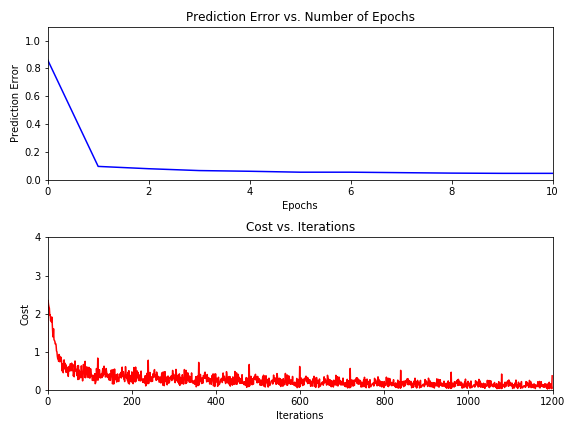

***** Training model *****
***** Training Complete *****


In [13]:
%matplotlib notebook
iter = 0
epoch = 0
cost_ij = 0
valid_losses = [valid_model(i) for i in range(n_valid_batches)]
valid_score = np.mean(valid_losses)
plt.ion()
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(211)
line1, = ax.plot(epoch, valid_score, 'b-')
ax.set_xlim(0, num_epochs)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Epochs')
ax.set_ylabel('Prediction Error')
ax.set_title('Prediction Error vs. Number of Epochs')

ax2 = fig.add_subplot(212)
line2, = ax2.plot(iter, cost_ij, 'r-')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Cost')
ax2.set_title('Cost vs. Iterations')
ax2.set_xlim(0, num_epochs * n_train_batches)
ax2.set_ylim(0, 4)
plt.tight_layout()
fig.show()


#### End of Visualisations Code ####

# This is where we call the previously defined Theano functions. 
print('***** Training model *****')
while (epoch < num_epochs):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):
        # Compute number of iterations performed or total number
        # of mini-batches executed.
        iter = (epoch - 1) * n_train_batches + minibatch_index
        
        # Perform the training of our convolution neural network.
        # Obtain the cost of each minibatch specified using the 
        # minibatch_index.
        cost_ij = train_model(minibatch_index)
        
        # Update the visualisation.
        update_cost_plot(line2, fig, iter, cost_ij)
        
    
    # Obtain the weights of the first convolutional layer.
    conv_weights = layer0_params[0].get_value()
    
    # Compute the prediction error on each validation mini-batch by
    # calling the previously defined Theano function for validation.
    valid_losses = [valid_model(i) for i in range(n_valid_batches)]
    
    # Compute the mean prediction error across all the mini-batches.
    valid_score = np.mean(valid_losses)
    
    # Update the visualisation.
    update_line(line1, fig, epoch, valid_score)
        
print('***** Training Complete *****')

<p>After the training is complete, we can evaluate the prediction accuracy of the trained Convolutional Neural Network over the unseen training set. This will give us a measure of how our trained model will perform on new unseen data.</p>

In [14]:
# Compute prediction errors on the test set for each mini-batch by
# calling the previous defined Theano function for evaluating our
# model's performance.
test_losses = [test_model(i) for i in range(n_test_batches)]

# Compute the mean prediction error across all the mini-batches.
test_score = np.mean(test_losses)
print('Prediction error: %f %%' % (test_score * 100.))

Prediction error: 5.200000 %


<p>Now, we can visualize the probability of a sampled image for digits [0, 9] </p>

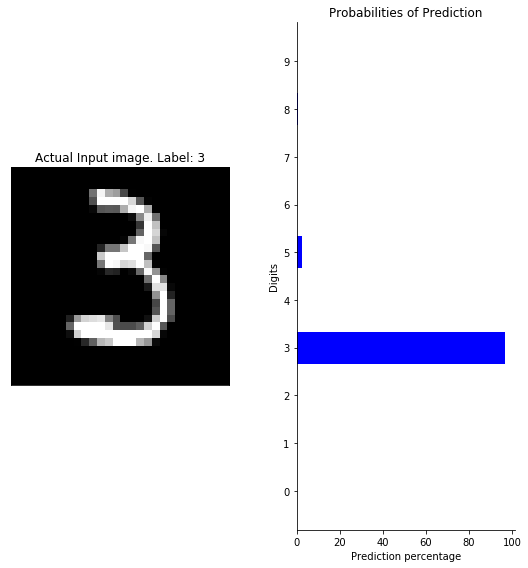

In [15]:
%matplotlib inline
plt.ioff()
# Choose a random image
image_plot = rd.randint(0, (train_size//3)-mini_batch_size)
# Create function to compute class-membership
# prediction probabilites.
f2 = theano.function([], p_y_given_x, givens={
        x: test_set_x[image_plot:image_plot+mini_batch_size]})

predictions = f2()
pred_image = predictions[0] * 100

# Parameters for bar chart of probabilities
N = len(pred_image)
x_axis = range(N)
width = 1/1.5

# Obtain convolution layer activations for sample
W_new = layer0_params[0].get_value()
b_new = layer0_params[1].get_value()
x_new = T.matrix('x')
inp_new = x.reshape((1, 1, 28, 28))

# Perform convolution operation
conv_op_out = conv2d(
       input=inp_new,
       filters=W_new,
       filter_shape=(num_filters[0], 1, 5, 5),
       input_shape=(1, 1, 28, 28))

# Pool the output
pooled_out = pooling(input_pool=conv_op_out,
                     size=(2,2))

# Obtain activations
output = T.tanh(pooled_out)

# Create function to obtain activations of conv layer
f = theano.function([], output, givens={
       x: test_set_x[image_plot:image_plot+1]})
test = f()

# Plotting code for sample, prediction probabilties and
# convolution layer activations
fig_actual = plt.figure(figsize=(8, 8))
ax_actual = fig_actual.add_subplot(121)
fig_actual.subplots_adjust(wspace=2)
pixels = np.array(test_set[0][image_plot] * 255,
                     dtype='uint8')
pixels = pixels.reshape((28, 28))
label = test_set[1][image_plot]
ax_actual.set_xticklabels([])
ax_actual.set_yticklabels([])
ax_actual.set_xticks([])
ax_actual.set_yticks([])
ax_actual.set_title(
    'Actual Input image. Label: {label}'.format(label=label))
ax_actual.imshow(pixels,
                 cmap='gray',
                 interpolation='none')

ax_prob = fig_actual.add_subplot(122)
ax_prob.set_yticks(x_axis)
ax_prob.barh(x_axis,
             pred_image,
             width,
             color='blue',
             align='center')
ax_prob.spines['right'].set_visible(False)
ax_prob.spines['top'].set_visible(False)
ax_prob.set_ylabel('Digits')
ax_prob.set_xlabel('Prediction percentage')
ax_prob.set_title('Probabilities of Prediction')
fig_actual.tight_layout()
plt.show()